In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
# At the beginning of image_processor.py
import cv2
import numpy as np
from ultralytics import YOLO
import sys
import os
import time
import json
import requests
import traceback
import math # For haversine/geo calculations

# --- Configuration --- (Keep your YOLO_MODEL_NAME, CONFIDENCE_THRESHOLD)
HERE_API_KEY = "YOUR_ACTUAL_HERE_API_KEY" # !!! REPLACE !!!
YOLO_MODEL_NAME = 'yolov8n.pt'
CONFIDENCE_THRESHOLD = 0.3

yolo_model_global = None # To store loaded model

# ... (Keep your load_yolo_model() function - rename from _colab if needed) ...
# ... (Keep your get_here_api_context() function - rename from _colab if needed) ...

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Cell 2: Imports and Global Configurations
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
import sys # Not strictly needed for Colab execution of functions, but good if adapting to .py
import time
import json
import requests
import traceback

# --- Configuration ---
YOLO_MODEL_NAME = 'yolov8n.pt'
# --- TUNABLE PARAMETER 1 ---
CONFIDENCE_THRESHOLD = 0.30
# --- TUNABLE PARAMETER 2 ---
CONGESTION_VEHICLE_COUNT_THRESHOLD = 4

VEHICLE_CLASS_IDS = [2, 3, 5, 7]

HERE_API_KEY = "YOUR_ACTUAL_HERE_API_KEY" #

colab_yolo_model = None # Global variable for the loaded model

print(f"Configuration: YOLO Model='{YOLO_MODEL_NAME}', Confidence Threshold={CONFIDENCE_THRESHOLD}, Congestion Threshold={CONGESTION_VEHICLE_COUNT_THRESHOLD}")
if HERE_API_KEY == "YOUR_ACTUAL_HERE_API_KEY":
    print("WARNING: HERE API Key is not set. HERE API calls will be skipped/fail gracefully.")

Configuration: YOLO Model='yolov8n.pt', Confidence Threshold=0.3, Congestion Threshold=4


In [4]:
def load_yolo_model_colab(model_name_to_load):
    global colab_yolo_model
    if colab_yolo_model is None:
        print(f"Loading YOLO model '{model_name_to_load}' for Colab...")
        try:
            colab_yolo_model = YOLO(model_name_to_load)
            print("YOLO model loaded successfully for Colab.")
            if hasattr(colab_yolo_model, 'names'):
                print("Model class names (first ~15 for reference):")
                for i, name in colab_yolo_model.names.items():
                    if i < 15:
                        print(f" ID {i}: {name}")  # Confirm vehicle IDs
                    else:
                        break
            else:
                print("Could not automatically retrieve class names from this model.")
        except Exception as e:
            print(f"Error loading YOLO model: {e}")
            colab_yolo_model = None
    else:
        print("YOLO model already loaded.")
    return colab_yolo_model


# Example usage
model_instance = load_yolo_model_colab(YOLO_MODEL_NAME)
print("\nYOLO model loading cell executed.")


Loading YOLO model 'yolov8n.pt' for Colab...


100%|██████████| 6.25M/6.25M [00:00<00:00, 83.1MB/s]

YOLO model loaded successfully for Colab.
Model class names (first ~15 for reference):
 ID 0: person
 ID 1: bicycle
 ID 2: car
 ID 3: motorcycle
 ID 4: airplane
 ID 5: bus
 ID 6: train
 ID 7: truck
 ID 8: boat
 ID 9: traffic light
 ID 10: fire hydrant
 ID 11: stop sign
 ID 12: parking meter
 ID 13: bench
 ID 14: bird

YOLO model loading cell executed.


In [5]:
def get_here_api_context_colab(latitude, longitude, api_key):
    if not api_key or api_key == "YOUR_ACTUAL_HERE_API_KEY":
        print("HERE API Key not provided or is placeholder. Skipping API call.")
        return {"error": "HERE API Key not configured."}
    reverse_geocode_url = f"https://revgeocode.search.hereapi.com/v1/revgeocode?at={latitude}%2C{longitude}&lang=en-US&limit=1&apiKey={api_key}"
    print(f"Calling HERE Reverse Geocode API for lat:{latitude}, lon:{longitude}")
    try:
        response = requests.get(reverse_geocode_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        if data.get("items") and len(data["items"]) > 0:
            item = data["items"][0]
            context = {
                "full_address": item.get("title", "N/A"),
                "street": item.get("address", {}).get("street", "N/A"),
                "city": item.get("address", {}).get("city", "N/A"),
                "country": item.get("address", {}).get("countryName", "N/A"),
                "latitude_searched": latitude,
                "longitude_searched": longitude,
            }
            print(f"HERE API Success: {context['full_address']}")
            return context
        else:
            print("No results from HERE Reverse Geocode API.")
            return {"error": "No results from HERE API."}
    except requests.exceptions.Timeout:
        print(f"HERE API Error: Request timed out.", file=sys.stderr)
        return {"error": "HERE API request timed out."}
    except requests.exceptions.RequestException as e:
        print(f"HERE API Error: Request failed: {e}", file=sys.stderr)
        return {"error": f"HERE API request failed: {e}"}
    except Exception as e:
        print(f"HERE API Error: Error processing response: {e}", file=sys.stderr)
        return {"error": f"Error processing HERE API response: {e}"}

print("HERE API context function defined.")

HERE API context function defined.


In [6]:
# Cell 5: Main Detection and Drawing Function
def process_image_for_colab(input_image_path, output_image_save_path,
                            yolo_model_to_use, here_api_key_to_use,
                            image_center_latitude=None, image_center_longitude=None):
    final_results_dict = {
        "input_image": input_image_path,
        "yolo_model_used": YOLO_MODEL_NAME,
        "yolo_confidence_threshold": CONFIDENCE_THRESHOLD,
        "congestion_vehicle_threshold": CONGESTION_VEHICLE_COUNT_THRESHOLD,
        "yolo_detections": [],
        "here_api_context": None,
        "alert_condition_met": False,
        "alert_reason": "No specific alert condition met.",
        "processed_image_saved_to": None,
        "error_message": None
    }

    if yolo_model_to_use is None:
        final_results_dict["error_message"] = "YOLO model not loaded."
        print(final_results_dict["error_message"])
        return final_results_dict

    if image_center_latitude is not None and image_center_longitude is not None:
        final_results_dict["here_api_context"] = get_here_api_context_colab(
            image_center_latitude, image_center_longitude, here_api_key_to_use
        )
    else:
        print("No latitude/longitude provided for image center, skipping HERE API context.")
        final_results_dict["here_api_context"] = {"message": "Location info not provided for HERE API call."}

    try:
        print(f"Reading image for YOLO: '{input_image_path}'")
        img = cv2.imread(input_image_path)
        if img is None:
            final_results_dict["error_message"] = f"Could not read image: {input_image_path}"
            print(final_results_dict["error_message"], file=sys.stderr)
            return final_results_dict

        annotated_img = img.copy()
        print("Running YOLO inference...")
        start_time = time.time()
        yolo_preds = yolo_model_to_use(img)
        end_time = time.time()
        print(f"YOLO Inference time: {end_time - start_time:.2f} seconds")

        vehicle_count_for_congestion = 0

        for result in yolo_preds:
            boxes = result.boxes
            names = result.names
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                if conf >= CONFIDENCE_THRESHOLD:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    label_name = names.get(cls_id, f"ID:{cls_id}")
                    final_results_dict["yolo_detections"].append({
                        "label": label_name, "class_id": cls_id,
                        "confidence": round(conf, 3), "bbox_pixels": [x1, y1, x2, y2]
                    })
                    color = (0,0,255) # Default Red for non-vehicles
                    if cls_id in VEHICLE_CLASS_IDS:
                        vehicle_count_for_congestion += 1
                        color = (0, 165, 255) # Orange for vehicles

                    display_text = f"{label_name} ({conf:.2f})"
                    text_y_pos = y1 - 10 if y1 > 20 else y1 + 20
                    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(annotated_img, display_text, (x1, text_y_pos),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        print(f"YOLO processed {len(final_results_dict['yolo_detections'])} features meeting confidence >= {CONFIDENCE_THRESHOLD}.")
        print(f"Vehicle count for congestion check: {vehicle_count_for_congestion}")

        if vehicle_count_for_congestion >= CONGESTION_VEHICLE_COUNT_THRESHOLD:
            final_results_dict["alert_condition_met"] = True
            final_results_dict["alert_reason"] = f"High vehicle density detected ({vehicle_count_for_congestion} vehicles), potential congestion."
            print(f"Alert condition MET: {final_results_dict['alert_reason']}")

        print("\nDisplaying Processed Image in Colab:")
        cv2_imshow(annotated_img)

        output_dir = os.path.dirname(output_image_save_path)
        if output_dir and not os.path.exists(output_dir): os.makedirs(output_dir)

        write_success = cv2.imwrite(output_image_save_path, annotated_img)
        if write_success:
            final_results_dict["processed_image_saved_to"] = output_image_save_path
            print(f"Processed image saved successfully to '{output_image_save_path}'.")
        else:
            final_results_dict["error_message"] = f"Failed to save image to {output_image_save_path}"
            print(final_results_dict["error_message"], file=sys.stderr)

    except Exception as e:
        final_results_dict["error_message"] = f"Unexpected error in YOLO processing: {str(e)}"
        print(final_results_dict["error_message"], file=sys.stderr)
        traceback.print_exc()

    return final_results_dict

print("Main Colab processing function defined.")

Main Colab processing function defined.



--- Starting Full Processing for andherieast.png ---
HERE API Key not provided or is placeholder. Skipping API call.
Reading image for YOLO: 'andherieast.png'
Running YOLO inference...

0: 512x640 6 persons, 4 cars, 1 bus, 1 truck, 1 traffic light, 45.1ms
Speed: 14.9ms preprocess, 45.1ms inference, 455.0ms postprocess per image at shape (1, 3, 512, 640)
YOLO Inference time: 10.89 seconds
YOLO processed 10 features meeting confidence >= 0.3.
Vehicle count for congestion check: 5
Alert condition MET: High vehicle density detected (5 vehicles), potential congestion.

Displaying Processed Image in Colab:


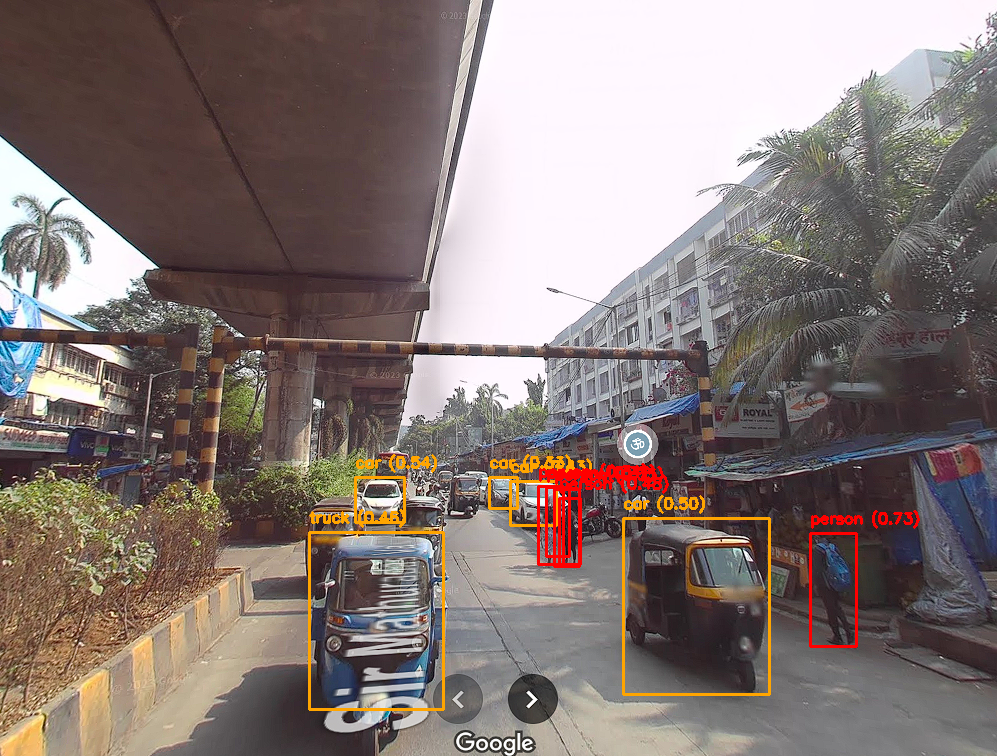

Processed image saved successfully to 'output_processed_hoover.png'.

--- FINAL RESULTS DICTIONARY (Colab Output) ---
{
  "input_image": "andherieast.png",
  "yolo_model_used": "yolov8n.pt",
  "yolo_confidence_threshold": 0.3,
  "congestion_vehicle_threshold": 4,
  "yolo_detections": [
    {
      "label": "person",
      "class_id": 0,
      "confidence": 0.732,
      "bbox_pixels": [
        810,
        533,
        856,
        646
      ]
    },
    {
      "label": "car",
      "class_id": 2,
      "confidence": 0.538,
      "bbox_pixels": [
        355,
        477,
        404,
        522
      ]
    },
    {
      "label": "car",
      "class_id": 2,
      "confidence": 0.498,
      "bbox_pixels": [
        623,
        518,
        769,
        694
      ]
    },
    {
      "label": "person",
      "class_id": 0,
      "confidence": 0.482,
      "bbox_pixels": [
        559,
        498,
        580,
        564
      ]
    },
    {
      "label": "truck",
      "class_id":

In [7]:
# Cell 6: Upload Image and Run Processing

# --- IMPORTANT: UPLOAD 'hoover.png' (or your test image) TO COLAB FIRST ---
# Use the File browser on the left.

INPUT_IMAGE_COLAB = 'andherieast.png'  # Or whatever you named your uploaded file
OUTPUT_IMAGE_COLAB = 'output_processed_hoover.png'

# --- Provide Approximate Coordinates for the Center of Your 'hoover.png' Image ---
# For "Cowper St, Palo Alto" area, these are roughly:
IMAGE_CENTER_LAT = 37.4468  # Example Lat for Cowper St, Palo Alto
IMAGE_CENTER_LON = -122.1586 # Example Lon for Cowper St, Palo Alto
# To skip HERE API for now (if key not working or not needed immediately):
# IMAGE_CENTER_LAT = None
# IMAGE_CENTER_LON = None


# --- Check if model and image are ready ---
if model_instance is None: # model_instance was loaded in Cell 3
    print("ERROR: YOLO model was not loaded successfully (check Cell 3). Cannot proceed.")
elif not os.path.exists(INPUT_IMAGE_COLAB):
    print(f"ERROR: Input image '{INPUT_IMAGE_COLAB}' not found in Colab session storage.")
    print("Please upload it using the file browser on the left before running this cell.")
else:
    print(f"\n--- Starting Full Processing for {INPUT_IMAGE_COLAB} ---")

    all_results_colab = process_image_for_colab(
        INPUT_IMAGE_COLAB,
        OUTPUT_IMAGE_COLAB,
        model_instance,
        HERE_API_KEY,
        IMAGE_CENTER_LAT,
        IMAGE_CENTER_LON
    )

    print("\n--- FINAL RESULTS DICTIONARY (Colab Output) ---")
    print(json.dumps(all_results_colab, indent=2)) # Pretty print

    if all_results_colab.get("processed_image_saved_to") and not all_results_colab.get("error_message"):
        print(f"\nSUCCESS! Output image at: {all_results_colab['processed_image_saved_to']}")
        print("Download it from the Colab file browser (refresh the browser if needed).")
    else:
        print(f"\nPROCESS FAILED or encountered issues. Error: {all_results_colab.get('error_message', 'Unknown error')}")

In [8]:
import json

# --- Configuration ---
CONFIG = {
    "crowd_alert": {
        "person_threshold": 7, # Let's use 7 to trigger with your sample data (9 persons)
    },
    "traffic_congestion": {
        "vehicle_threshold": 6, # Cars+Trucks+Bicycle = 5+2+1 = 8. Let's use 6 to trigger.
        "vehicle_labels": ["car", "truck", "bus", "motorcycle", "bicycle"]
    },
    "marketplace_activity": {
        "person_threshold": 5,
        "umbrella_threshold": 1,
    },
    "construction_site_hint": { # This is a weak heuristic with current labels
        "truck_threshold": 1,
        # "other_construction_labels": ["traffic cone", "excavator", "bulldozer"] # Add if your model detects these
    }
}

# --- Your Sample YOLO Output (as a Python dictionary) ---
# (Based on the JSON you provided in the prompt)
yolo_results_data = {
  "input_image": "ggg.png",
  "yolo_model_used": "yolov8n.pt",
  "yolo_detections": [
    {"label": "umbrella", "class_id": 25, "confidence": 0.88, "bbox_pixels": [16,379,344,494]},
    {"label": "bicycle", "class_id": 1, "confidence": 0.807, "bbox_pixels": [904,473,1054,629]},
    {"label": "truck", "class_id": 7, "confidence": 0.715, "bbox_pixels": [843,249,1279,638]},
    {"label": "person", "class_id": 0, "confidence": 0.712, "bbox_pixels": [368,422,421,565]},
    {"label": "person", "class_id": 0, "confidence": 0.699, "bbox_pixels": [84,471,230,694]},
    {"label": "person", "class_id": 0, "confidence": 0.662, "bbox_pixels": [921,403,1013,566]},
    {"label": "car", "class_id": 2, "confidence": 0.643, "bbox_pixels": [798,379,856,449]},
    {"label": "person", "class_id": 0, "confidence": 0.619, "bbox_pixels": [264,447,333,645]},
    {"label": "umbrella", "class_id": 25, "confidence": 0.578, "bbox_pixels": [278,359,407,411]},
    {"label": "person", "class_id": 0, "confidence": 0.531, "bbox_pixels": [335,419,378,538]},
    {"label": "car", "class_id": 2, "confidence": 0.481, "bbox_pixels": [736,367,816,430]},
    {"label": "car", "class_id": 2, "confidence": 0.443, "bbox_pixels": [657,410,792,575]},
    {"label": "person", "class_id": 0, "confidence": 0.44, "bbox_pixels": [467,379,499,439]},
    {"label": "truck", "class_id": 7, "confidence": 0.432, "bbox_pixels": [657,412,792,575]},
    {"label": "person", "class_id": 0, "confidence": 0.399, "bbox_pixels": [34,485,131,671]},
    {"label": "car", "class_id": 2, "confidence": 0.34, "bbox_pixels": [666,369,709,405]},
    {"label": "person", "class_id": 0, "confidence": 0.337, "bbox_pixels": [546,374,561,401]},
    {"label": "car", "class_id": 2, "confidence": 0.326, "bbox_pixels": [708,365,743,401]},
    {"label": "person", "class_id": 0, "confidence": 0.314, "bbox_pixels": [905,408,1003,551]}
  ],
  "here_api_context": {
    "full_address": "Sutter Health Palo Alto Medical Foundation",
    "street": "N/A", "city": "Palo Alto", "country": "United States",
    "latitude_searched": 37.44, "longitude_searched": -122.16
  },
  "processed_image_saved_to": "output_processed_hoover.png",
  "error": None
}


def generate_notifications(yolo_output, config):
    """
    Generates notifications based on YOLO detections and predefined rules.
    """
    detections = yolo_output.get("yolo_detections", [])
    if not detections:
        return ["No YOLO detections found."]

    notifications = []

    # --- Count relevant objects ---
    counts = {
        "person": 0,
        "car": 0,
        "truck": 0,
        "bus": 0,
        "motorcycle": 0,
        "bicycle": 0,
        "umbrella": 0,
        # Add other relevant objects if needed, e.g., "traffic cone"
    }

    for det in detections:
        label = det.get("label")
        if label in counts:
            counts[label] += 1

    total_vehicles = sum(counts[label] for label in config["traffic_congestion"]["vehicle_labels"] if label in counts)

    # --- Apply rules ---

    # 1. Crowd Alert
    if counts["person"] > config["crowd_alert"]["person_threshold"]:
        notifications.append(
            f"NOTIFICATION: Crowd Alert! Detected {counts['person']} people "
            f"(Threshold: >{config['crowd_alert']['person_threshold']})."
        )

    # 2. Traffic Congestion
    if total_vehicles > config["traffic_congestion"]["vehicle_threshold"]:
        notifications.append(
            f"NOTIFICATION: Traffic Congestion Alert! Detected {total_vehicles} vehicles "
            f"(Threshold: >{config['traffic_congestion']['vehicle_threshold']}). "
            f"(Cars: {counts['car']}, Trucks: {counts['truck']}, Bicycles: {counts['bicycle']})" # etc.
        )

    # 3. Marketplace Activity
    if (counts["person"] > config["marketplace_activity"]["person_threshold"] and
            counts["umbrella"] > config["marketplace_activity"]["umbrella_threshold"]):
        notifications.append(
            f"NOTIFICATION: Potential Marketplace Activity! Detected {counts['person']} people "
            f"and {counts['umbrella']} umbrellas. "
            f"(Thresholds: >{config['marketplace_activity']['person_threshold']} people, "
            f">{config['marketplace_activity']['umbrella_threshold']} umbrellas)."
        )

    # 4. Potential Construction Site (Weak Heuristic)
    # You might want to add more specific labels if your model supports them
    # construction_objects_found = 0
    # if "other_construction_labels" in config["construction_site_hint"]:
    #     for label in config["construction_site_hint"]["other_construction_labels"]:
    #         construction_objects_found += counts.get(label, 0)

    if counts["truck"] > config["construction_site_hint"]["truck_threshold"]: # and construction_objects_found > 0 (if using specific labels)
        notifications.append(
            f"NOTIFICATION: Potential Construction Activity Hint! Detected {counts['truck']} trucks. "
            f"(Truck Threshold: >{config['construction_site_hint']['truck_threshold']}). Consider visual inspection."
        )
        # Add more logic if other construction indicators are present

    if not notifications:
        notifications.append("INFO: No specific alert conditions met based on current thresholds.")

    return notifications

# --- Main execution ---
if __name__ == "__main__":
    # In a real scenario, yolo_results_data would come from your YOLO processing script

    # For demonstration, print the counts first:
    print("--- Object Counts (from provided JSON) ---")
    temp_counts = {"person": 0, "car": 0, "truck": 0, "bicycle": 0, "umbrella": 0}
    for d in yolo_results_data["yolo_detections"]:
        lbl = d["label"]
        if lbl in temp_counts:
            temp_counts[lbl] += 1
    for k, v in temp_counts.items():
        print(f"{k.capitalize()}: {v}")
    print("-" * 20)

    generated_notifications = generate_notifications(yolo_results_data, CONFIG)

    print("\n--- Generated Notifications ---")
    if generated_notifications:
        for notification in generated_notifications:
            print(notification)
    else:
        print("No notifications generated.")

    # You can also include the location if relevant:
    # context = yolo_results_data.get("here_api_context")
    # if context:
    # print(f"\nContext Location: {context.get('full_address', 'N/A')}")

--- Object Counts (from provided JSON) ---
Person: 9
Car: 5
Truck: 2
Bicycle: 1
Umbrella: 2
--------------------

--- Generated Notifications ---
NOTIFICATION: Crowd Alert! Detected 9 people (Threshold: >7).
NOTIFICATION: Traffic Congestion Alert! Detected 8 vehicles (Threshold: >6). (Cars: 5, Trucks: 2, Bicycles: 1)
NOTIFICATION: Potential Marketplace Activity! Detected 9 people and 2 umbrellas. (Thresholds: >5 people, >1 umbrellas).
NOTIFICATION: Potential Construction Activity Hint! Detected 2 trucks. (Truck Threshold: >1). Consider visual inspection.
